In [3]:
from PIL import Image, ImageChops
from random import shuffle, randint, choice
import math
from functools import reduce
import operator

In [4]:
# Ключ, используемый для шифрования послания. Длина ключа должна быть равна длине одного символа
ORIGIN = 0b101001
KEY = int(ORIGIN)

In [5]:
# Считывание изображения шахматной доски
base = Image.open("images/base.png")

# Координаты первой клетки и размеры клетки
left, top = 20, 20
width, height = 45, 45

# Считывание изображений шахматных фигур
pieces = {}
for item in ("bishop", "rook", "knight", "king", "queen", "pawn"):
    wh = Image.open(f"images/black-{item}.png")
    wh.thumbnail((width, height))
    white = Image.new("RGBA", (width, height), "black")
    white.paste(wh, (0, 0), wh)
    
    bl = Image.open(f"images/white-{item}.png")
    bl.thumbnail((width, height))
    black = Image.new("RGBA", (width, height), "white")
    black.paste(bl, (0, 0), bl)

    pieces[item] = (white, black)

In [6]:
# Функция добавления шахматной фигуры на доску
def add_piece(dest, piece, row, column):
    piece_image = pieces[piece][(row + column + 1) % 2]
    x = int(left + column * width)
    y = int(top + row * height)
    dest.paste(piece_image, (x, y), piece_image)

In [7]:
# Кодировка символов
chars_encoding = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
            'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13,
            'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20,
            'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '.': 26, ',': 27,
            '!': 28, '?': 29, ' ': 30, '\n': 31, '0': 32, '1': 33, '2': 34,
            '3': 35, '4': 36, '5': 37, '6': 38, '7': 39, '8': 40, '9': 41,
            'А': 0, 'Б': 42, 'В': 1, 'Г': 43, 'Д': 44, 'Е': 4, 'Ё': 45,
            'Ж': 46, 'З': 47, 'И': 48, 'Й': 49, 'К': 10, 'Л': 50, 'М': 12,
            'Н': 7, 'О': 14, 'П': 51, 'Р': 15, 'С': 2, 'Т': 19, 'У': 52,
            'Ф': 53, 'Х': 23, 'Ц': 54, 'Ч': 55, 'Ш': 56, 'Щ': 57, 'Ъ': 58,
            'Ы': 59, 'Ь': 60, 'Э': 61, 'Ю': 62, 'Я': 63}
chars_decoding = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
            8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
            15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V',
            22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '.', 27: ',', 28: '!',
            29: '?', 30: ' ', 31: '\n', 32: '0', 33: '1', 34: '2', 35: '3',
            36: '4', 37: '5', 38: '6', 39: '7', 40: '8', 41: '9', 42: 'Б',
            43: 'Г', 44: 'Д', 45: 'Ё', 46: 'Ж', 47: 'З', 48: 'И', 49: 'Й',
            50: 'Л', 51: 'П', 52: 'У', 53: 'Ф', 54: 'Ц', 55: 'Ч', 56: 'Ш',
            57: 'Щ', 58: 'Ъ', 59: 'Ы', 60: 'Ь', 61: 'Э', 62: 'Ю', 63: 'Я'}

In [8]:
# Симметричное шифрование (Шифр Вернама)
def crypto(code):
    global KEY
    # Инкремент ключа шифрования
    KEY += 3
    KEY %= 0b111111
    return code ^ KEY

In [9]:
# Перевод текста в строку из единиц и нулей
def encode_text(message):
    global KEY
    KEY = ORIGIN
    sequence = []
    # Перевод всех символов строки в заглавные символы
    for char in message.upper():
        # Количество единиц, идущих подряд
        value = 0
        # Перевод символа в строку из единиц и нулей
        for key in format(crypto(chars_encoding[char]), "06b"):
            if key == "1":
                value += 1
            else:
                if value != 0:
                    sequence.append(value)
                sequence.append(0)
                value = 0
        if value != 0:
            sequence.append(value)
    return sequence

In [10]:
# Перевод строки из единиц и нулей в текст
def decode_text(sequence):
    # Сброс ключа шифрования на изначальный
    global KEY
    KEY = ORIGIN
    
    message = list()
    for code in sequence:
        message.append(chars_decoding[crypto(int(code, 2))])
    return "".join(message)

In [11]:
# Значения (длины последовательностей из единиц), кодируемые шахматными фигурами
chess_encoding = sorted(
    {1: ["pawn", "king", "bishop"], 2: ["rook"], 3: ["knight"]}
    .items(), reverse=True
                       )
chess_decoding = {
    "pawn": 1, "king": 1, "bishop": 1, "rook": 2, "knight": 3
}

In [12]:
# Преобразование текста в шахматное стего
def encode_images(message, sequence=None, first=True):
    # Выбор координаты индикатора начала послания
    start = randint(0, 4)
    index = start
    image = base.copy()
    
    # Добавление индикатора начала послания
    add_piece(image, "queen", index // 8, index % 8)
    index += 1
    
    # В случае, если функция вызвана повторно, следует кодировать с того места, на котором остановились
    sequence = sequence or encode_text(message)
    images = [image]
    
    # Оставшееся количество фигур
    amounts = {"pawn": 16, "king": 2, "rook": 4, "knight": 4, "bishop": 4}
    
    for i, seq in enumerate(sequence):
        # В случае, если поле заканчивается
        if index >= 63:
            # Добавление индикатоар окончания послания
            add_piece(image, "queen", index // 8, index % 8)
            
            # Повторный вызов преобразования для оставшейся последовательности
            images.extend(encode_images(None, [seq, *sequence[i + 1:]], False))
            break
        
        # Пропуск клетки
        if seq == 0:
            index += 1
        
        # k - количество единиц, задаваемое каждой из фигур в v
        for (k, v) in chess_encoding:
            # В случае, если поле заканчивается
            if index >= 63:
                break
            
            # Пока количество подряд идущих единиц больше либо равно k
            while seq >= k:
                # Случайное перемешивание фигур, задавающих одно количество единиц
                shuffle(v)
                
                # Попытка добавить каждую из фигур
                for piece in v:
                    # Если осталась такая фигура
                    if amounts[piece] > 0:
                        amounts[piece] -= 1
                        seq -= k
                        add_piece(image, piece, index // 8, index % 8)
                        index += 1
                        break
                else:
                    # Если не осталось фигур из v
                    break
                
                # В случае, если поле заканичивается
                if index >= 63:
                    break
        
        # Если не получилось закодировать символ
        if seq != 0:
            # Добавление индикатор окончания послания
            add_piece(image, "queen", index // 8, index % 8)
            # Повторный вызов преобразования для оставшейся последовательности
            images.extend(encode_images(None, [seq, *sequence[i + 1:]], False))
            break
    else:
        # Если послание окончилось
        
        # Если на поле осталось место
        add_piece(image, "queen", index // 8, index % 8)
    
    # Добавление лишних фигур
    cells = [*range(0, start), *range(index + 1, 64)]
    shuffle(cells)
    
    left = []
    for k, v in amounts.items():
        for _ in range((v + 1) // 3):
            left.append(k)
    
    shuffle(left)
    
    while len(cells) != 0 and len(left) != 0:
        item = choice(left)
        index = choice(cells)
        cells.remove(index)
        left.remove(item)
        add_piece(image, item, index // 8, index % 8)
    
    return images

In [13]:
# Функция-индикатор для распознования соответствия шахматной фигуры образцу
def indicator(origin, pattern):
    # Получаем гистограмму разницы образца и фигуры
    hist = ImageChops.difference(origin, pattern).histogram()
    # Возвращаение среднего квадратического отклонения
    return math.sqrt(reduce(operator.add,
        map(lambda h, i: h * i ** 2, hist, range(256))
    ) / (float(origin.size[0]) * origin.size[1]))

In [14]:
# Распознование шахматной фигуры
def recognize_piece(image, row, column):   
    # Выделение изображение клетки
    start = (left + width * column, top + height * row)
    end = (left + width * (column + 1), top + height * (row + 1))
    origin = image.crop((*start, *end))
    
    # Поиск образца шахматной фигуры, для которого среднее квадратическое отклонение минимально
    # Если отклонение больше 30, то, скорее всего, шахматной фигуры в клетке нет
    best, value = None, 30
    for name, patterns in pieces.items():
        # Выбор наименьшего из отклонений для черной и белой версии фигуры
        val = min(indicator(origin, patterns[0]), indicator(origin, patterns[1]))
        if val < value:
            value = val
            best = name
    
    return best

In [15]:
# Преобразование изображений в последовательности из единиц и нулей
def decode_images(images):
    result = list()
    table = list()
    
    # Распознавание шахматных фигур в каждом из изображений      
    for image in images:
        for i in range(8):
            for j in range(8):
                table.append(recognize_piece(image, i, j))
                
    cnt = table.count("queen")
    # Если ферзей на всех шахматных полей не кратно двум, то данные поля не могут раскодироваться в сообщение
    if cnt % 2 == 0:
        # Переход к началу первого шахматного поля
        table = table[table.index("queen") + 1:]
        cnt -= 1
        # Параметр, принимающий True в том случае, если послание на прошлом шахматном поле 
        # закончилось, но еще не началось на следующем
        locked = False
        for item in table:
            if item == "queen":
                cnt -= 1
                # Если этот ферзь - последний, то дальше нет послания
                if cnt == 0:
                    break
                locked = not locked
            # Если послание еще не закончилось
            elif not locked:
                if item is None:
                    result.append("0")
                else:
                    result.append("1" * chess_decoding[item])
        
        # Преобразование послания в последовательность из единиц и нулей
        line = "".join(result)
        
        # Разбиение послания на части, размером в один символ (6 бит)
        # Если длина последователности не кратна размеру символа, то послания нет или оно повреждено
        if len(line) % 6 == 0:
            return ["".join(line[i:i + 6]) for i in range(0, len(line), 6)]
    return None

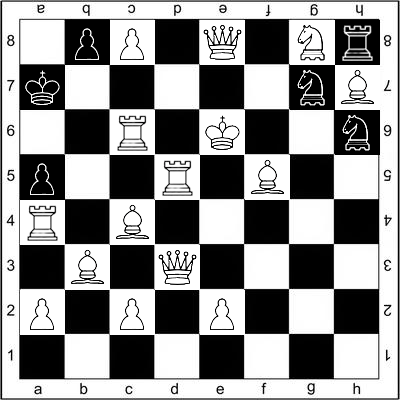

In [22]:
images = encode_images("Проверка")
display(*images)

In [23]:
decode_text(decode_images(images))

'ПPOBEPKA'